In [1]:
from matplotlib import pyplot as plt
from tifffile import imread
import numpy as np
import pickle
from hydra.experimental import compose, initialize
import os
import torch
from lpu3dnet.frame import vqgan
from lpu3dnet.frame import transformer

# initialize configuration parameters for a specific experiment
experiment = 'ex12'
initialize(config_path=f"../config/{experiment}")
cfg_vqgan = compose(config_name="vqgan")
cfg_transformer = compose(config_name="transformer")
cfg_dataset = compose(config_name="dataset")

def read_pickle(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)
    

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


#### Check physical attributes

Transformer sampled $64^3$. Multi-token generation without assembling

In [2]:
# read pickle file
real_phys = read_pickle(f'db/real_phys.pkl')
generate_phys = read_pickle(f'db/generate_phys.pkl')

In [3]:
phi_real = []
phi_gen = []
k_real = []
k_gen = []
eul_real = []
eul_gen = []

for ds_real, ds_gen in zip(real_phys,generate_phys):
    if ds_real and ds_gen:
        phi_real.append(ds_real['porosity'])
        phi_gen.append(ds_gen['porosity'])
        k_real.append(ds_real['kabs'][0])
        k_gen.append(ds_gen['kabs'][0])
        eul_real.append(ds_real['euler'])
        eul_gen.append(ds_gen['euler'])

In [4]:
transformer_phys = read_pickle(f'db/generate_phys_transformer.pkl')

phi_gen = []
k_gen = []
eul_gen = []

for ds_gen in transformer_phys:
    if ds_gen:
        phi_gen.append(ds_gen['porosity'])
        k_gen.append(ds_gen['kabs'][0])
        eul_gen.append(ds_gen['euler'])

In [5]:
# make sure the length of the arrays are the same
# random select number of samples from phi_gen
num_phi = min(len(phi_gen),len(phi_real))
num_k = min(len(k_gen),len(k_real))
num_eul = min(len(eul_gen),len(eul_real))


# randomly select num_phi samples
idx = np.random.choice(len(phi_gen),num_phi,replace=False)
phi_gen = np.array(phi_gen)[idx]

idx = np.random.choice(len(k_gen),num_k,replace=False)
k_gen = np.array(k_gen)[idx]

idx = np.random.choice(len(eul_gen),num_eul,replace=False)
eul_gen = np.array(eul_gen)[idx]


#### Transformer sampled $64^3$ block

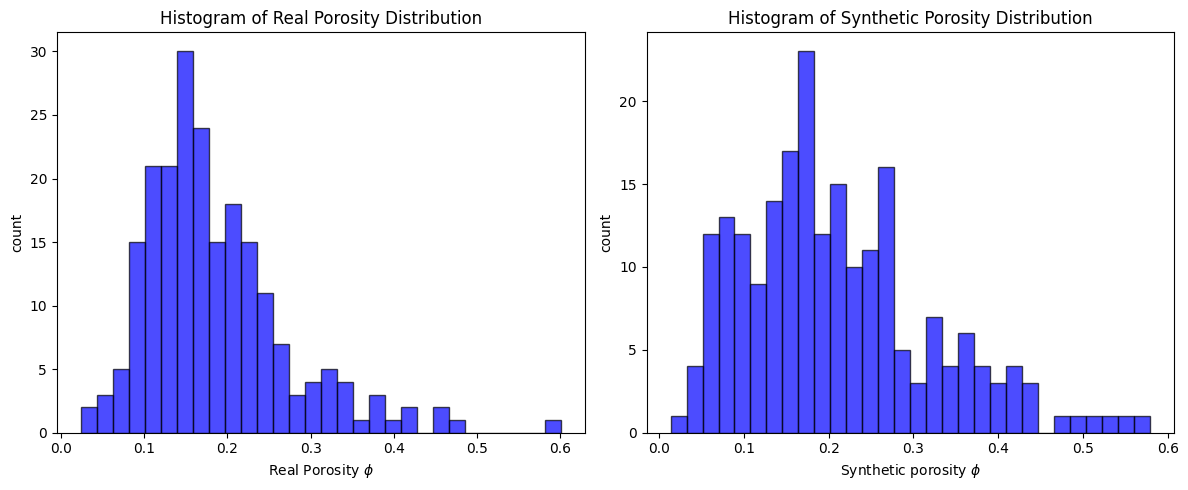

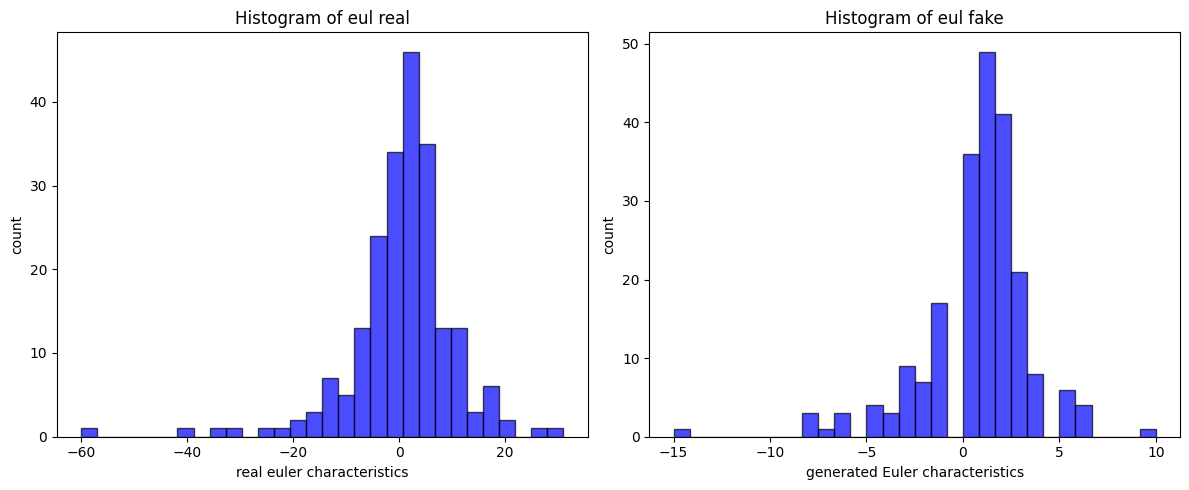

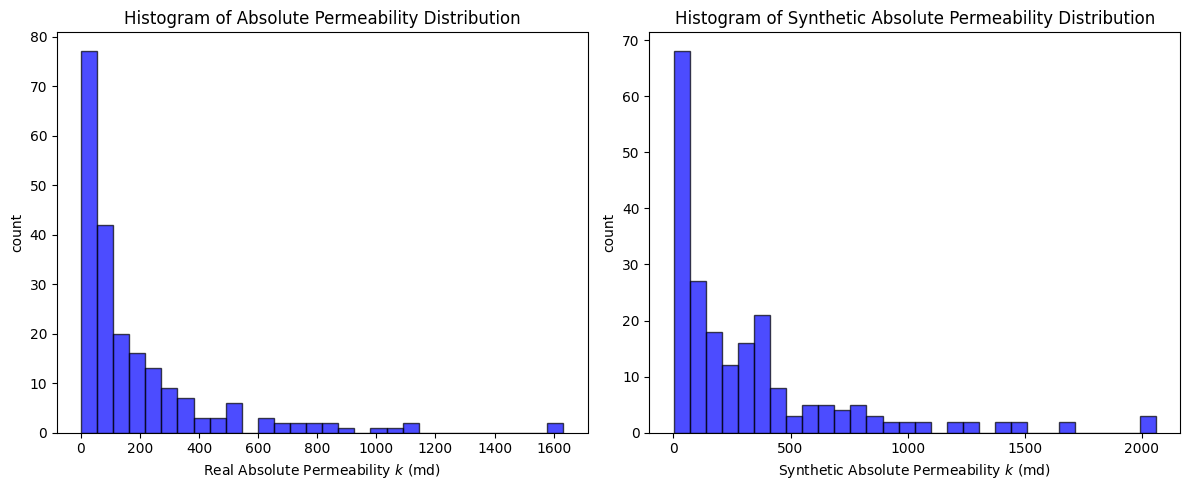

In [18]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first histogram
ax[0].hist(phi_real, bins=30, edgecolor='black', facecolor='blue', alpha=0.7)
ax[0].set_xlabel('Real Porosity $\phi$')
ax[0].set_ylabel('count')
ax[0].set_title('Histogram of Real Porosity Distribution')

# Plot the second histogram
ax[1].hist(phi_gen, bins=30, edgecolor='black', facecolor='blue', alpha=0.7)
ax[1].set_xlabel('Synthetic porosity $\phi$')
ax[1].set_ylabel('count')
ax[1].set_title('Histogram of Synthetic Porosity Distribution')

# Display the figure with the histograms
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure
plt.show()

f, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first histogram
ax[0].hist(eul_real, bins=30, edgecolor='black', facecolor='blue', alpha=0.7)
ax[0].set_xlabel('real euler characteristics')
ax[0].set_ylabel('count')
ax[0].set_title('Histogram of eul real')

# Plot the second histogram
ax[1].hist(eul_gen, bins=30, edgecolor='black', facecolor='blue', alpha=0.7)
ax[1].set_xlabel('generated Euler characteristics')
ax[1].set_ylabel('count')
ax[1].set_title('Histogram of eul fake')

# Display the figure with the histograms
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure
plt.show()


f, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first histogram
ax[0].hist(k_real, bins=30, edgecolor='black', facecolor='blue', alpha=0.7)
ax[0].set_xlabel('Real Absolute Permeability $k$ (md)')
ax[0].set_ylabel('count')
ax[0].set_title('Histogram of Absolute Permeability Distribution')

# Plot the second histogram
ax[1].hist(k_gen, bins=30, edgecolor='black', facecolor='blue', alpha=0.7)
ax[1].set_xlabel('Synthetic Absolute Permeability $k$ (md)')
ax[1].set_ylabel('count')
ax[1].set_title('Histogram of Synthetic Absolute Permeability Distribution')

# Display the figure with the histograms
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure
plt.show()

In [6]:
from lpu3dnet.inference import block_generation_singlecond

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

block_generator = block_generation_singlecond.Block_generator_stochastic(
    cfg_dataset,
    cfg_vqgan,
    cfg_transformer,
    epoch_vqgan=25,
    epoch_transformer=50,
    device = device,
    volume_dimension=5
    )

block_generator.generate_block(repeat=4)

number of parameters: 183.73M


#### Visualize individual transformer sampled blocks

* stochastically generate transformer blocks with porosity range from [0.05,0.35]

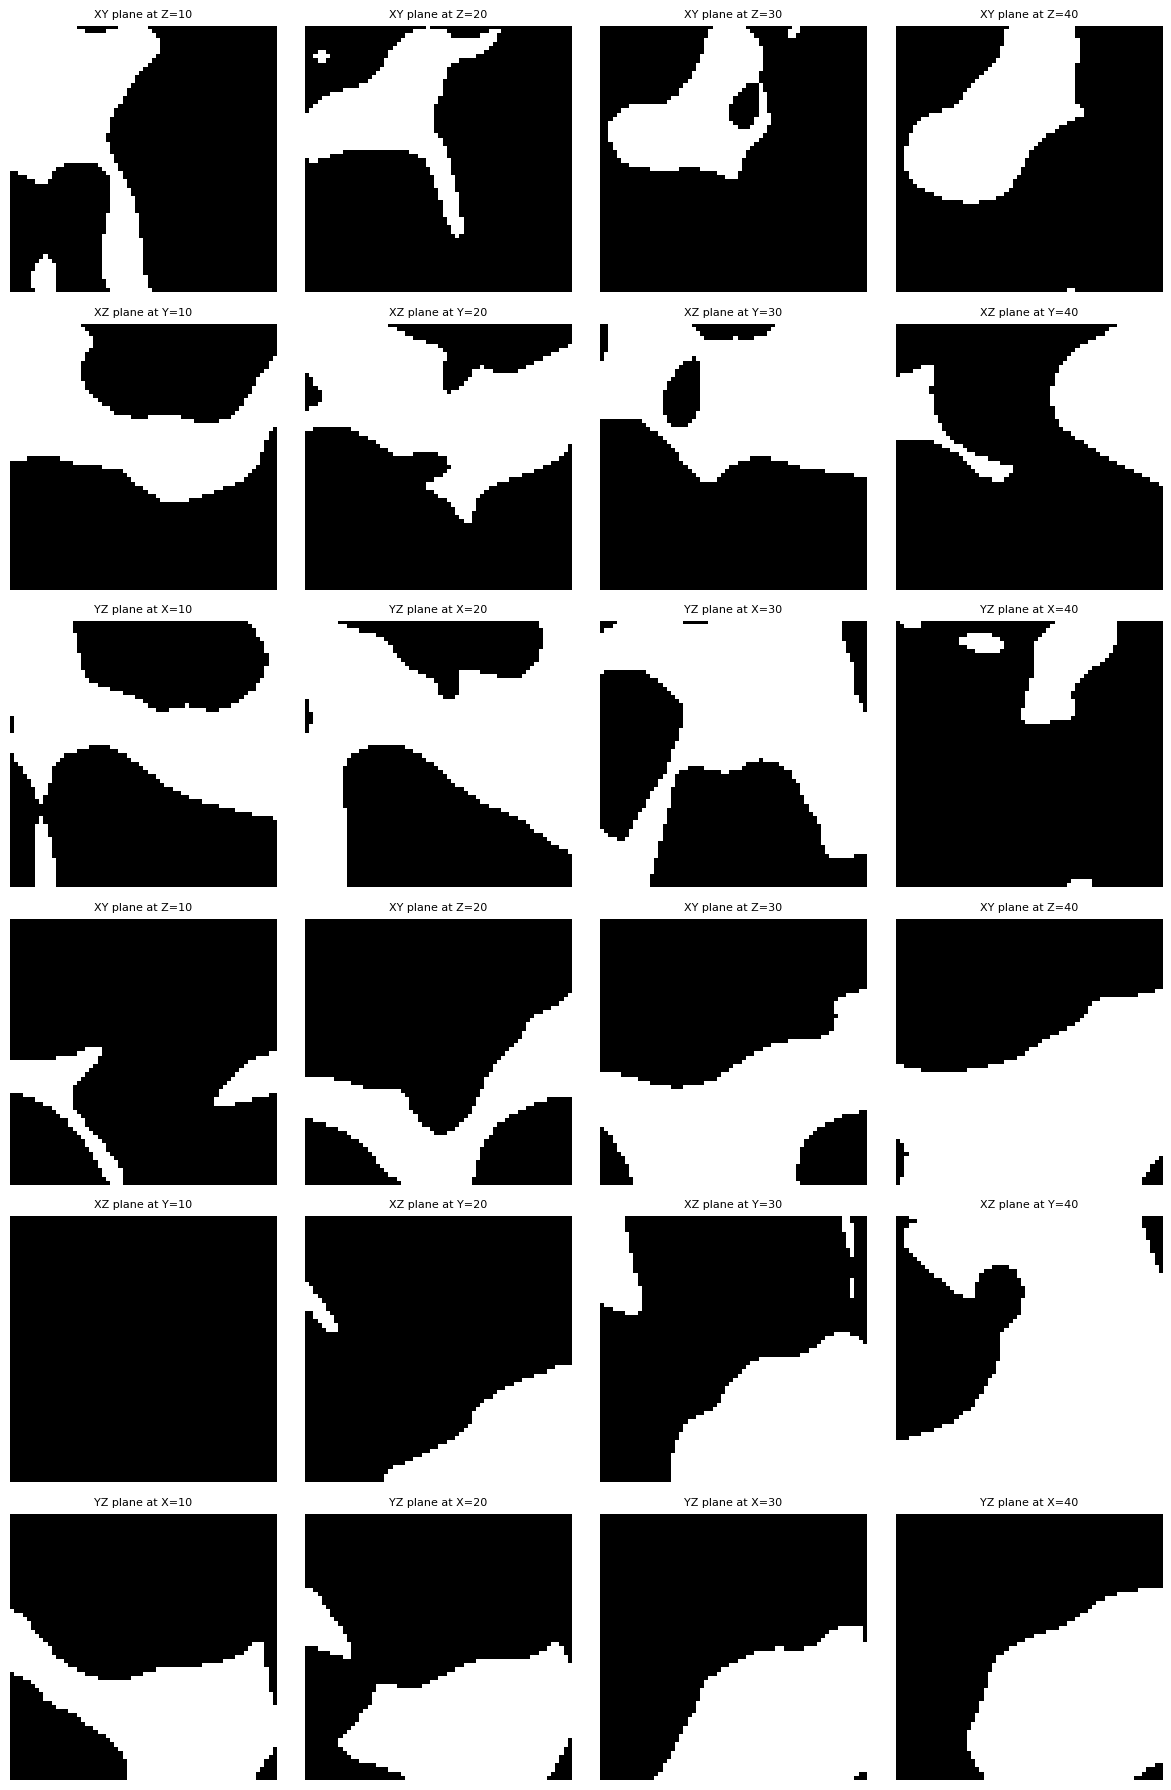

In [26]:
ds_data  = block_generator.ds_spatial
img_list = []
for coord in ds_data.keys():
    ds = ds_data[coord]
    img_list.append(ds['img'])

img_arr = np.array(img_list)
import random


def visualize_planes_grid_extended(img_arr):
    fig, axs = plt.subplots(6, 4, figsize=(12, 18))
    
    # Select two different random image indices
    img_index_1 = random.randint(0, img_arr.shape[0] - 1)
    img_index_2 = random.randint(0, img_arr.shape[0] - 1)
    
    # Define the slice indices to demonstrate the evolution with steps of 10
    slice_indices = [10, 20, 30, 40]
    
    for i in range(6):
        for j in range(4):
            if i < 3:  # First three rows, using img_index_1
                img_index = img_index_1
            else:  # Last three rows, using img_index_2
                img_index = img_index_2
            
            # Determine the plane and slice index based on the row
            if i % 3 == 0:  # XY plane evolution in the first and fourth row
                slice_index = slice_indices[j]
                slice_2d = img_arr[img_index, :, :, slice_index]
                title = f'XY plane at Z={slice_index}'
            elif i % 3 == 1:  # XZ plane evolution in the second and fifth row
                slice_index = slice_indices[j]
                slice_2d = img_arr[img_index, slice_index, :, :]
                title = f'XZ plane at Y={slice_index}'
            else:  # YZ plane evolution in the third and sixth row
                slice_index = slice_indices[j]
                slice_2d = img_arr[img_index, :, slice_index, :]
                title = f'YZ plane at X={slice_index}'
            
            # Display the 2D slice
            axs[i, j].imshow(slice_2d, cmap='gray')
            axs[i, j].set_title(title, fontsize=8)
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_planes_grid_extended(img_arr)


#### Stochastic reoonstruction of large volume ($640^3$)

In [2]:
from lpu3dnet.inference import block_generation_singlecond

def visualize_planes_grid_single(img_arr):
    """
    Visualizes 2D slices from a single 3D image in a 3x6 grid.
    
    Parameters:
    img_arr (numpy.ndarray): A 3D numpy array with shape (196, 196, 196).
    """
    # Define the slice indices for visualization
    slice_indices = [20, 50, 80, 110, 140, 170]

    # Create a 3x6 grid for visualization
    fig, axs = plt.subplots(3, 6, figsize=(18, 9))

    for i in range(3):  # Three different planes
        for j in range(6):  # Six different slices
            slice_index = slice_indices[j]

            # Determine the plane and slice to display
            if i == 0:  # XY plane evolution
                slice_2d = img_arr[:, :, slice_index]
                title = f'XY plane at Z={slice_index}'
            elif i == 1:  # XZ plane evolution
                slice_2d = img_arr[:, slice_index, :]
                title = f'XZ plane at Y={slice_index}'
            else:  # YZ plane evolution
                slice_2d = img_arr[slice_index, :, :]
                title = f'YZ plane at X={slice_index}'

            # Display the 2D slice
            axs[i, j].imshow(slice_2d, cmap='gray')
            axs[i, j].set_title(title, fontsize=8)
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()



number of parameters: 183.73M


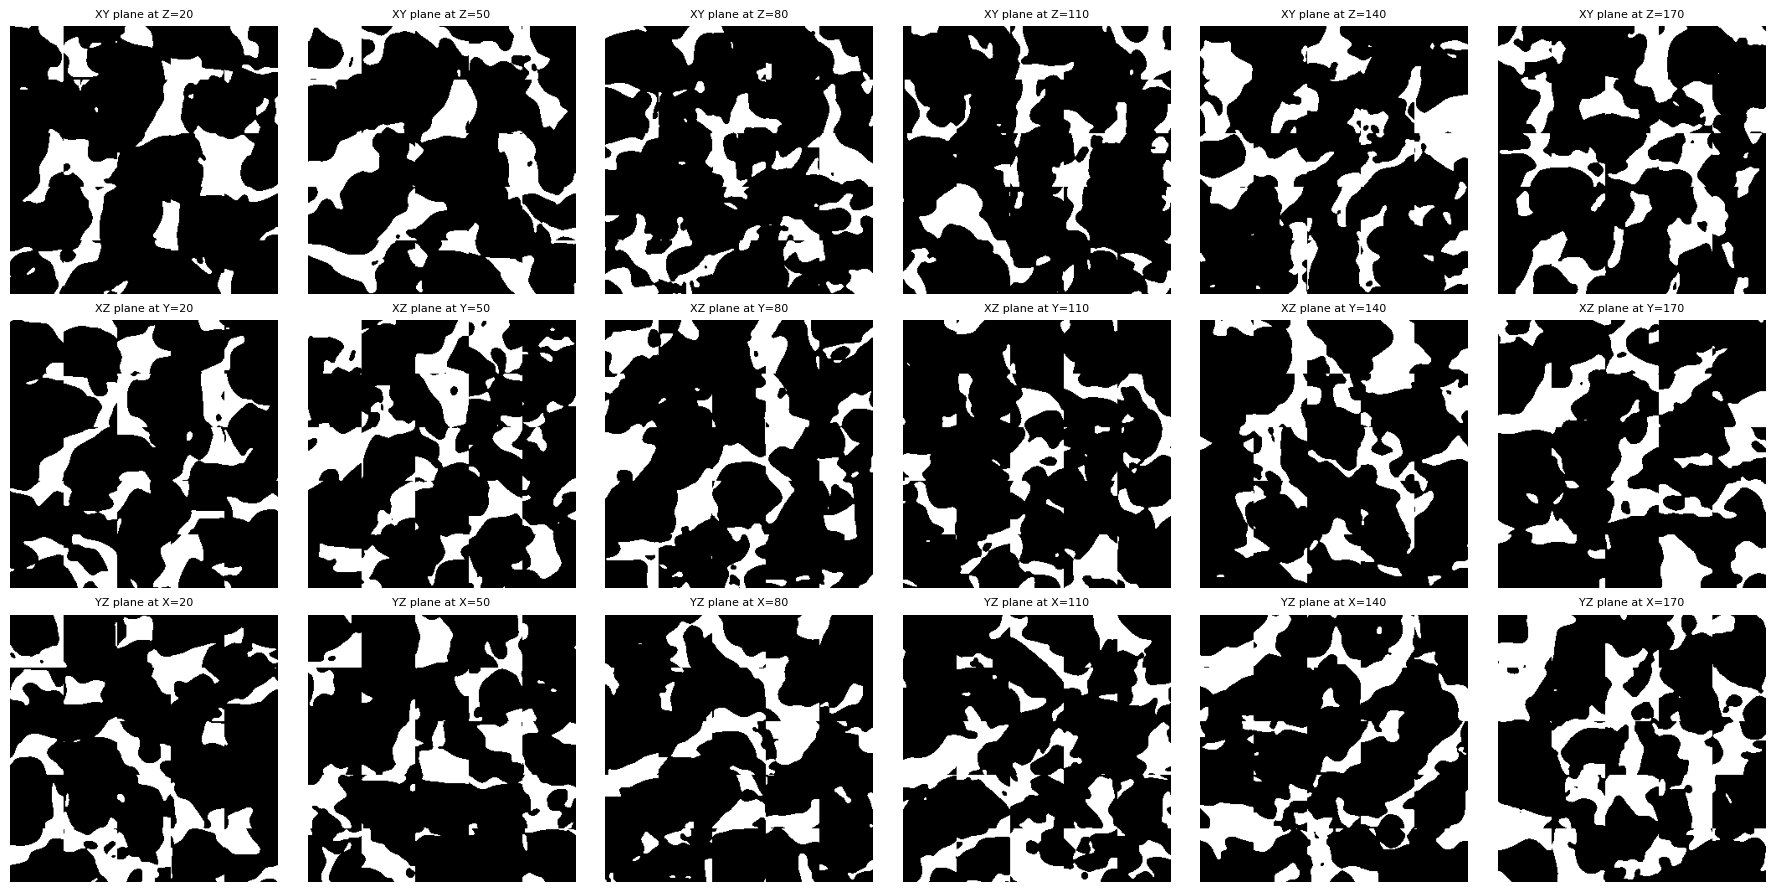

In [18]:
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

block_generator = block_generation_singlecond.Block_generator_stochastic(
    cfg_dataset,
    cfg_vqgan,
    cfg_transformer,
    epoch_vqgan=25,
    epoch_transformer=50,
    device = device,
    volume_dimension=5
    )

block_generator.generate_block(repeat=4)

def get_volume_shape(ds_spatial):
    max_i, max_j, max_k = 0, 0, 0
    for ijk in ds_spatial.keys():
        i, j, k = ijk
        max_i = max(max_i, i)
        max_j = max(max_j, j)
        max_k = max(max_k, k)
    return max_i + 1, max_j + 1, max_k + 1

def assemble_volume(ds_spatial):
    volume_shape = get_volume_shape(ds_spatial)
    volume = np.zeros((volume_shape[0] * 64, volume_shape[1] * 64, volume_shape[2] * 64))

    for ijk, data in ds_spatial.items():
        i, j, k = ijk
        image = data['img']
        volume[i*64:(i+1)*64, j*64:(j+1)*64, k*64:(k+1)*64] = image

    return volume

volume = assemble_volume(block_generator.ds_spatial)
# plt.imshow(volume[:,90,:], cmap='gray')
visualize_planes_grid_single(volume)

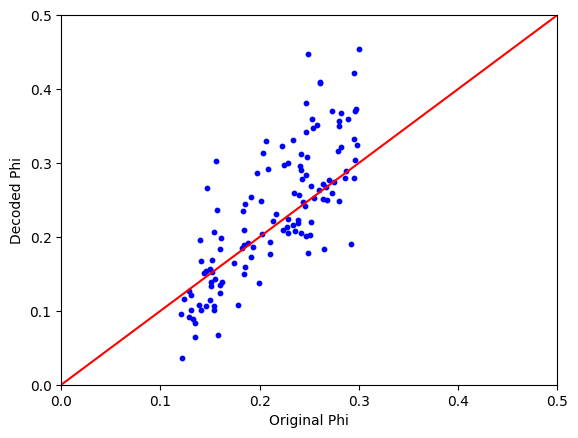

Mean Absolute Error: 0.046034020721912386


In [20]:
phi_list = []
phi_gen_list = []


from cpgan.ooppnm import img_process
img_prc = img_process.Image_process()

ds_spatial = block_generator.ds_spatial
for keys in ds_spatial.keys():
    phi_list.append(ds_spatial[keys]['phi'])
    img = ds_spatial[keys]['img']
    phi_gen = img_prc.phi(img)
    phi_gen_list.append(phi_gen)


# phi_list_cal = [x*0.6936 + 0.05 for x in phi_gen_list]

f = plt.figure()
val_max = 0.5
plt.scatter(phi_list, phi_gen_list,s=10,c='b')
plt.plot([0,val_max],[0,val_max],c='r')
plt.xlim([0,val_max])
plt.ylim([0,val_max])
plt.xlabel('Original Phi')
plt.ylabel('Decoded Phi')
plt.show()



# f = plt.figure()

# plt.scatter(phi_list, phi_list_cal,s=10,c='b')
# plt.plot([0,val_max],[0,val_max],c='r')
# plt.xlim([0,val_max])
# plt.ylim([0,val_max])
# plt.xlabel('Original Phi')
# plt.ylabel('Decoded Phi')
# plt.show()


# calculate mean absolute error between phi_list

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(phi_list, phi_gen_list)
print(f'Mean Absolute Error: {mae}')

# mae_cali = mean_absolute_error(phi_list, phi_list_cal)
# print(f'Mean Absolute Error: {mae_cali}')